Fazendo baselines zero-shot/few-shot com o BERTimbau para ver se o GANBERT tem o efeito desejado

In [1]:
#pra conseguir algum erro util da porra do torch
import os
#os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from transformers import pipeline, AutoTokenizer, BertForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, average_precision_score,f1_score
from tqdm import tqdm
import random
import torch
import time
import datetime
from skmultilearn.skmultilearn.model_selection.iterative_stratification import iterative_train_test_split
from sklearn.utils.class_weight import compute_class_weight


tqdm.pandas()

In [3]:
seed_val = 2023
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
if torch.cuda.is_available():
  torch.cuda.manual_seed_all(seed_val)
  device = 0

In [4]:
num_train_epochs = 40
print_each_n_step = 10
batch_size= 16
learning_rate = 5e-5


In [5]:
class EarlyStopper:
    def __init__(self, patience=4, min_delta=0,is_loss=True):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.is_loss = is_loss
        if is_loss:
            self.min_validation_loss = np.inf
        else:
            self.min_validation_loss = -np.inf

    def early_stop(self, validation_loss):
        if self.is_loss:
            if validation_loss < self.min_validation_loss:
                self.min_validation_loss = validation_loss
                self.counter = 0
                print("NEW LOWEST LOSS ",self.min_validation_loss)
            elif validation_loss >= (self.min_validation_loss + self.min_delta):
                self.counter += 1
                if self.counter >= self.patience:
                    return True
            return False
        
        else:
            if validation_loss > self.min_validation_loss:
                self.min_validation_loss = validation_loss
                self.counter = 0
                print("NEW HIGHEST SCORE ",self.min_validation_loss)
            elif validation_loss <= (self.min_validation_loss + self.min_delta):
                self.counter += 1
                if self.counter >= self.patience:
                    return True
            return False

In [6]:
stop = EarlyStopper(is_loss=True)

In [7]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [8]:
device = 0 if torch.cuda.is_available() else -1
remove_neutral_instances= False


# Dados

In [9]:
#df = pd.read_csv("data/segredos_sentenças_multitask_clean.csv",index_col=0)
#df['Alteração na eficiência/funcionalidade'] == 1 or df['Perda/Diminuição do prazer/ Perda/Diminuição da libido'] == 1

In [10]:
#df = df.drop(["Postagem com possível perfil depressivo","Alteração na eficiência",
#         "Alteração da funcionalidade","*",'Agitação/inquietação','Sintoma obsessivo e compulsivo','Déficit de atenção/Memória',
#              'Perda/Diminuição do prazer/ Perda/Diminuição da libido'],axis=1)

In [11]:
#symptom_num = df.iloc[:,1:].shape[1]
#target_names = list(df.iloc[:,1:].columns)


In [12]:
#if remove_neutral_instances == True:
#    df = df.reset_index(drop=True)
#    df = df[df.iloc[:,1:].sum(axis=1) != 0]
    

In [13]:
#df = df.reset_index(drop=True)

In [14]:
#from skmultilearn.skmultilearn.model_selection.iterative_stratification import IterativeStratification
#strat = IterativeStratification(n_splits=2).split(df,df.iloc[:,1:])

In [15]:
#train_df,_,test_df, _ = iterative_train_test_split(df,df.iloc[:,1:],test_size=0.5)

In [16]:
#from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

#strat = MultilabelStratifiedKFold(n_splits=2, shuffle=True, random_state=seed_val).split(df,df.iloc[:,1:])

In [17]:
#for train_idx, test_idx in strat:

#    train_df = df.loc[train_idx]
#    test_df  = df.loc[test_idx]
#    break

In [18]:
#for train_index,test_index in iterator:
    #print(train_index)
    #print(test_index)
#    train_df = df.loc[train_index]
#    test_df = df.loc[test_index]

In [19]:
#label_to_idx = {sintoma:i for i,sintoma in enumerate(label_list)}
#idx_to_label = {i:sintoma for i,sintoma in enumerate(label_list)}

In [20]:
def process_data(df):
    df['Alteração na eficiência/funcionalidade'] = (df['Alteração na eficiência/funcionalidade'] == 1) | (df["Alteração da funcionalidade"] == 1) | (df["Alteração na eficiência"] == 1)
    df = df.drop(["Postagem com possível perfil depressivo","Alteração na eficiência",
         "Alteração da funcionalidade","*",'Agitação/inquietação','Sintoma obsessivo e compulsivo','Déficit de atenção/Memória',
              'Perda/Diminuição do prazer/ Perda/Diminuição da libido'],axis=1)
    df['Neutro'] =  df.iloc[:,1:].sum(axis=1) == 0
    df = df.replace({True:1,False:0})
    if remove_neutral_instances == True:
        df = df.reset_index(drop=True)
        df = df[df.iloc[:,1:].sum(axis=1) != 0]
    df = df.reset_index(drop=True)
    return df


train_df = process_data(pd.read_csv("data/segredos_sentenças_multitask_train_clean.csv",index_col=0))
test_df = process_data(pd.read_csv("data/segredos_sentenças_multitask_test_clean.csv",index_col=0))




symptom_num = train_df.iloc[:,1:].shape[1]
target_names = list(train_df.iloc[:,1:].columns)


In [21]:
#dataloaders

max_length = 128

def get_dataloader(df,tokenizer,batch_size,do_shuffle):
    examples = []
    input_ids = []
    attention_masks = []
    for text in df.text:
        encoded = tokenizer.encode_plus(text,return_attention_mask=True,add_special_tokens=True,max_length = max_length,
    padding="max_length",truncation=True)
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    

    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)
    labels = torch.tensor(df.iloc[:,1:].to_numpy(),dtype=torch.float32)
    
    dataset = torch.utils.data.TensorDataset(input_ids,attention_masks,labels)
    
    if do_shuffle:
        sampler = torch.utils.data.RandomSampler
    else:
        sampler = torch.utils.data.SequentialSampler
    return torch.utils.data.DataLoader(dataset,sampler = sampler(dataset),batch_size=batch_size)
    
       

## Finetuning de tudo???

In [25]:
#pra quando eu quiser debuggar e o blocking não ajudar
#device = "cpu"

In [26]:
model_path = "neuralmind/bert-base-portuguese-cased"
#model_path = "adalbertojunior/distilbert-portuguese-cased"

In [27]:
model = BertForSequenceClassification.from_pretrained(model_path,num_labels=symptom_num)
tokenizer = AutoTokenizer.from_pretrained(model_path)

Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the

In [28]:
train_dataloader = get_dataloader(train_df,tokenizer,batch_size,do_shuffle=True)
test_dataloader = get_dataloader(test_df,tokenizer,batch_size,do_shuffle=False)

In [29]:
model = model.to(device)

In [30]:
#para referência https://link.springer.com/chapter/10.1007/978-3-642-38679-4_37
#e também https://www.kaggle.com/code/rejpalcz/best-loss-function-for-f1-score-metric

#por algum motivo foi pior do que otimizar por BCE...
#ainda é bom deixar guardado aqui, vai que é útil um dia!
def f1_differentiable_loss(sigmoid_vals,labels):
    #em caso de precisão ou recall igual a 0
    eps=1e-10
    #estamos tratando das probabilidades.
    #por exemplo, se labels é [0,1] e temos a prob [0.3,0.9]
    #temos um true positive rate de 0 + 0.9
    # um true negative rate de 0.7 + 0
    # um false positive rate de 0.3
    # e por fim um false negative rate de 0.1
    tp = torch.sum(labels*sigmoid_vals)
    tn = torch.sum((1-labels)*(1-sigmoid_vals))
    fp = torch.sum((1-labels)*sigmoid_vals)
    fn = torch.sum(labels * (1-sigmoid_vals))
    
    p = tp / (tp + fp) + eps
    r = tp / (tp + fn) +eps
    
    f1 = 2*p*r/ (p+r) + eps
    #queremos minimizar a perda de f1, portanto 1-f1
    return 1-f1.mean()

In [31]:
#fazendo minha própria focal loss porque a focal loss do kornia não funfa. 
#Por que o cara do pytorch mentiu pra mim ;_; ??

def focal_loss(inputs,target,alpha=1,gamma=2):
    #lembrando que a focal loss é só uma CE com "modulating factors"[
    base = torch.nn.BCELoss()(inputs,target)
    prob_diffs = (target - inputs).abs()
    loss = alpha *( (prob_diffs**gamma) * base )
    return loss.mean()
    
    
def focal_binary_cross_entropy(p, targets, gamma=4):
    #l = logits.reshape(-1)
    #t = targets.reshape(-1)
    #p = torch.sigmoid(l)
    p = torch.where(targets >= 0.5, p, 1-p)
    logp = - torch.log(torch.clamp(p, 1e-4, 1-1e-4))
    loss = logp*((1-p)**gamma)
    num_label = targets.shape[1]
    loss = num_label*loss.mean()
    return loss

In [32]:
def new_and_improved(p,targets,gamma=3,alpha=0.8):
    bce = torch.nn.functional.binary_cross_entropy(p,targets,reduction='none')
    p = torch.where(targets == 1,p,1-p)
    alpha = targets * alpha + (1-targets) * (1 - alpha)
    return (alpha * (1 - p) ** gamma).mean()

In [33]:
def find_best_threshold(true_labels, probs):
    eps=1e-10
    thresholds = [i*0.1 for i in range(1,10)]
    max_score = 0
    for threshold in thresholds:
        cur_score = f1_score(true_labels,probs>threshold,average="macro")
        if cur_score > max_score:
            max_score = cur_score
            best_threshold = threshold
    return best_threshold


In [34]:
def mixup(batch_ids,batch_labels,alpha=1):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = batch_ids.size()[0]
 
    index = torch.randperm(batch_size).cuda()

    
    mixed_x = lam * batch_ids + (1 - lam) * batch_ids[index, :]
    #using bigger input mask
    #mixed_masks = batch_masks | batch_masks[index,:]
    y_a, y_b = batch_labels, batch_labels[index]
    return mixed_x, y_a, y_b, lam

In [35]:
def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

In [32]:
#model.dropout.p = 0.5

In [36]:
def get_inverse_class_freqs(data):
    return 1 -torch.tensor(data.sum()/data.shape[0]).to(device)

In [37]:
#usando regularização SMART
from smart_pytorch import SMARTLoss, kl_loss, sym_kl_loss



In [38]:
from typing import Union, Callable
from torch import Tensor
from itertools import count 


def exists(val):
    return val is not None

def default(val, d):
    if exists(val):
        return val
    return d
    
def inf_norm(x):
    return torch.norm(x, p=float('inf'), dim=-1, keepdim=True)

class Fix(torch.nn.Module):
    
    
    

    
    
    def __init__(self,
        eval_fn: Callable,
        loss_fn: Callable,
        loss_last_fn: Callable = None, 
        norm_fn: Callable = inf_norm, 
        num_steps: int = 1,
        step_size: float = 1e-3, 
        epsilon: float = 1e-6,
        noise_var: float = 1e-5):
    
        super().__init__()
        self.eval_fn = eval_fn 
        self.loss_fn = loss_fn
        self.loss_last_fn = default(loss_last_fn, loss_fn)
        self.norm_fn = norm_fn
        self.num_steps = num_steps 
        self.step_size = step_size
        self.epsilon = epsilon 
        self.noise_var = noise_var
        
    def forward(self, embed: Tensor, state: Tensor,noise) -> Tensor:
        
        # Indefinite loop with counter 
        for i in count():
            # Compute perturbed embed and states

            embed_perturbed = embed + noise
            state_perturbed = self.eval_fn(embed_perturbed)
            # Return final loss if last step (undetached state)
            if i == self.num_steps: 
                return self.loss_last_fn(state_perturbed, state) 
            # Compute perturbation loss (detached state)
            loss = self.loss_fn(state_perturbed, state.detach())
            # Compute noise gradient ∂loss/∂noise

            
            noise_gradient, = torch.autograd.grad(loss, noise)
            # Move noise towards gradient to change state as much as possible 
            step = noise + self.step_size * noise_gradient 
            # Normalize new noise step into norm induced ball 
            step_norm = self.norm_fn(step)
            noise = step / (step_norm + self.epsilon)
            # Reset noise gradients for next step
            
            noise = noise.detach().requires_grad_()
    

In [39]:
class ModelWrapper(torch.nn.Module):
    
    def __init__(self,model,weight = 0.02):
        super().__init__()
        self.model = model
        self.weight = weight
        
    def forward(self,input_ids,attention_mask,labels):
        
        embed = self.model.bert.embeddings(input_ids)
        
        def eval_fn(embed):
            outputs = self.model(inputs_embeds=embed,attention_mask=attention_mask)
            #pooled_output = outputs[1]

            #logits = self.model.classifier(pooled_output)
            return outputs[0]
        noise = torch.randn_like(embed, requires_grad=True)
        
        smart_loss_fn = Fix(eval_fn = eval_fn, loss_fn = kl_loss,loss_last_fn=sym_kl_loss)
        
        state = eval_fn(embed)
        loss = new_and_improved(torch.nn.functional.sigmoid(state),labels)
        loss += self.weight * smart_loss_fn(embed,state,noise)
        
        return state, loss
    
wrapper_model = ModelWrapper(model).to(device)

In [40]:
training_stats = []

total_t0 = time.time()

model_vars = [i for i in wrapper_model.parameters()]
optimizer =  torch.optim.AdamW(model_vars, lr= learning_rate)


#lembrando que a função sigmoid é um "s" com o "meio" em x=0 y=0.5
threshold = 0.5 
#loss_func = torch.nn.BCELoss()
#loss_func = f1_differentiable_loss
#loss_func = focal_binary_cross_entropy
#loss_func = lambda x,y: new_and_improved(x,y,gamma=3,alpha=get_inverse_class_freqs(train_df.iloc[:,1:]))
loss_func = new_and_improved
sigmoid = torch.sigmoid
best_f1 = 0
best_epoch = 0
best_report = {}
best_auc = 0

for epoch_i in range(0,num_train_epochs):

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, num_train_epochs))
    print('Training...')
    t0 = time.time()
    
    tr_loss = 0
    
    model.train()
    all_probs = []
    all_labels_ids = []
    for step, batch in enumerate(train_dataloader):
        if step % print_each_n_step == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        cur_batch_size = b_input_ids.shape[0]
        
        
        output,loss = wrapper_model(b_input_ids,attention_mask = b_input_mask,labels=b_labels)
        #output,targets_a,targets_b,lam = mixup(output.logits,b_labels)

        
        all_probs += sigmoid(output).detach().cpu()
        all_labels_ids += b_labels.detach().cpu()
        #loss = mixup_criterion(loss_func,sigmoid(output),targets_a,targets_b,lam)
        #loss = loss_func(sigmoid(output.logits),b_labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        tr_loss += loss.item()
    
    all_probs = torch.stack(all_probs).numpy()
    all_labels_ids = torch.stack(all_labels_ids).numpy()
    
    threshold = find_best_threshold(all_labels_ids,all_probs)
    auc = average_precision_score(all_labels_ids,all_probs)
    print("AUC: ",auc)
    
    avg_train_loss = tr_loss/len(train_dataloader)
    
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.3f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
    
    print("")
    print("Running Test...")
    
    model.eval()
    total_test_loss = 0
    all_probs = []
    all_labels_ids = []
    for batch in test_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        with torch.no_grad():
            outputs = model(b_input_ids,attention_mask = b_input_mask)
            total_test_loss += loss_func(sigmoid(outputs.logits),b_labels)
            preds = sigmoid(outputs.logits)
        all_probs += preds.detach().cpu()
        all_labels_ids += b_labels.detach().cpu()
    all_probs = torch.stack(all_probs).numpy()
    all_preds = all_probs > threshold
    all_labels_ids = torch.stack(all_labels_ids).numpy()
    cur_report = classification_report(all_labels_ids,all_preds,target_names=target_names, zero_division=0,output_dict=True)
    
    cur_auc = average_precision_score(all_labels_ids,all_probs)
    
    if cur_auc > best_auc:
        #só pra ter certeza
        assert cur_auc != average_precision_score(all_labels_ids,all_probs,average='micro')
        best_auc = cur_auc
        best_auc_epoch = epoch_i
        best_probs = all_probs
        best_labels = all_labels_ids
        
        
        model.save_pretrained("models/BERT baselines")

        
    if cur_report['macro avg']['f1-score'] >= best_f1:
        best_f1 = cur_report['macro avg']['f1-score']
        best_epoch = epoch_i
        best_report = cur_report

        
    avg_test_loss = total_test_loss / len(test_dataloader)
    avg_test_loss = avg_test_loss.item()
    
    test_time = format_time(time.time() - t0)
    print("F1-score: ",cur_report['macro avg']['f1-score'])
    print("  Test Loss: {0:.3f}".format(avg_test_loss))
    print("  Test took: {:}".format(test_time))
    if stop.early_stop(avg_test_loss):
        break
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Test Loss': avg_test_loss,
            'F1-score':cur_report['macro avg']['f1-score'],
            'Training Time': training_time,
            'Test Time': test_time
        })


======== Epoch 1 / 40 ========
Training...
  Batch    10  of    243.    Elapsed: 0:00:06.
  Batch    20  of    243.    Elapsed: 0:00:11.
  Batch    30  of    243.    Elapsed: 0:00:17.
  Batch    40  of    243.    Elapsed: 0:00:22.
  Batch    50  of    243.    Elapsed: 0:00:28.
  Batch    60  of    243.    Elapsed: 0:00:33.
  Batch    70  of    243.    Elapsed: 0:00:39.
  Batch    80  of    243.    Elapsed: 0:00:45.
  Batch    90  of    243.    Elapsed: 0:00:50.
  Batch   100  of    243.    Elapsed: 0:00:56.
  Batch   110  of    243.    Elapsed: 0:01:01.
  Batch   120  of    243.    Elapsed: 0:01:07.
  Batch   130  of    243.    Elapsed: 0:01:12.
  Batch   140  of    243.    Elapsed: 0:01:18.
  Batch   150  of    243.    Elapsed: 0:01:23.
  Batch   160  of    243.    Elapsed: 0:01:29.
  Batch   170  of    243.    Elapsed: 0:01:35.
  Batch   180  of    243.    Elapsed: 0:01:40.
  Batch   190  of    243.    Elapsed: 0:01:46.
  Batch   200  of    243.    Elapsed: 0:01:52.
  Batch   210  o

  Batch    10  of    243.    Elapsed: 0:00:06.
  Batch    20  of    243.    Elapsed: 0:00:11.
  Batch    30  of    243.    Elapsed: 0:00:17.
  Batch    40  of    243.    Elapsed: 0:00:22.
  Batch    50  of    243.    Elapsed: 0:00:28.
  Batch    60  of    243.    Elapsed: 0:00:33.
  Batch    70  of    243.    Elapsed: 0:00:39.
  Batch    80  of    243.    Elapsed: 0:00:45.
  Batch    90  of    243.    Elapsed: 0:00:50.
  Batch   100  of    243.    Elapsed: 0:00:56.
  Batch   110  of    243.    Elapsed: 0:01:01.
  Batch   120  of    243.    Elapsed: 0:01:07.
  Batch   130  of    243.    Elapsed: 0:01:12.
  Batch   140  of    243.    Elapsed: 0:01:18.
  Batch   150  of    243.    Elapsed: 0:01:24.
  Batch   160  of    243.    Elapsed: 0:01:29.
  Batch   170  of    243.    Elapsed: 0:01:35.
  Batch   180  of    243.    Elapsed: 0:01:40.
  Batch   190  of    243.    Elapsed: 0:01:46.
  Batch   200  of    243.    Elapsed: 0:01:52.
  Batch   210  of    243.    Elapsed: 0:01:57.
  Batch   220

In [41]:
best_fine_tuning_report = best_report
best_fine_tuning_epoch = best_epoch

In [42]:
print("BEST AUC: ",best_auc)
print("epoch", best_auc_epoch)

BEST AUC:  0.3741775259669953
epoch 7


In [43]:
best_probs.shape

(848, 19)

In [44]:
from sklearn.metrics import precision_recall_curve
preds = []
for i in range (best_probs.shape[1]):
    precision,recall,thresholds = precision_recall_curve(best_labels[:,i],best_probs[:,i])
    f1_scores = 2*recall*precision/(recall+precision)
    cur_threshold = thresholds[np.nanargmax(f1_scores)]
    print("melhor f1 para ",train_df.columns[i+1]," ",np.nanmax(f1_scores))
    preds.append(best_probs[:,i] >= cur_threshold)

melhor f1 para  Alteração de sono   0.47058823529411764
melhor f1 para  Alteração na eficiência/funcionalidade   0.4230769230769231
melhor f1 para  Tristeza/Humor depressivo   0.634920634920635
melhor f1 para  Desamparo/Prejuízo social/Solidão   0.5405405405405405
melhor f1 para  Suicído/Auto-extermínio   0.6530612244897959
melhor f1 para  Preocupação/Medo /Ansiedade   0.6666666666666666
melhor f1 para  Desesperança   0.3414634146341463
melhor f1 para  Desvalia / Baixa autoestima   0.417910447761194
melhor f1 para  Fator de risco   0.35532994923857864
melhor f1 para  Irritação / agressividade   0.15584415584415584
melhor f1 para  Sintoma físico   0.33333333333333337
melhor f1 para  Sentimento de culpa   0.27450980392156865
melhor f1 para  Morte / Suicído de outro   0.6
melhor f1 para  Fator protetivo, cuidado em saúde e bem-estar   0.44680851063829785
melhor f1 para  Dificuldade para decidir   0.2
melhor f1 para  Cansaço/Desânimo/Desencorajamento/Fadiga/Perda de energia / Lentificação 

/tmp/ipykernel_3898/438058958.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2*recall*precision/(recall+precision)
/tmp/ipykernel_3898/438058958.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2*recall*precision/(recall+precision)
/tmp/ipykernel_3898/438058958.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2*recall*precision/(recall+precision)
/tmp/ipykernel_3898/438058958.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2*recall*precision/(recall+precision)
/tmp/ipykernel_3898/438058958.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2*recall*precision/(recall+precision)
/tmp/ipykernel_3898/438058958.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2*recall*precision/(recall+precision)
/tmp/ipykernel_3898/438058958.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2*recall*precision/(recall+precision)
/tmp/ipykernel_3898/

In [45]:
best_preds = np.array(preds).T
best_fine_tuning_report = classification_report(best_labels,best_preds,target_names=target_names, zero_division=0,output_dict=True)


<AxesSubplot:>

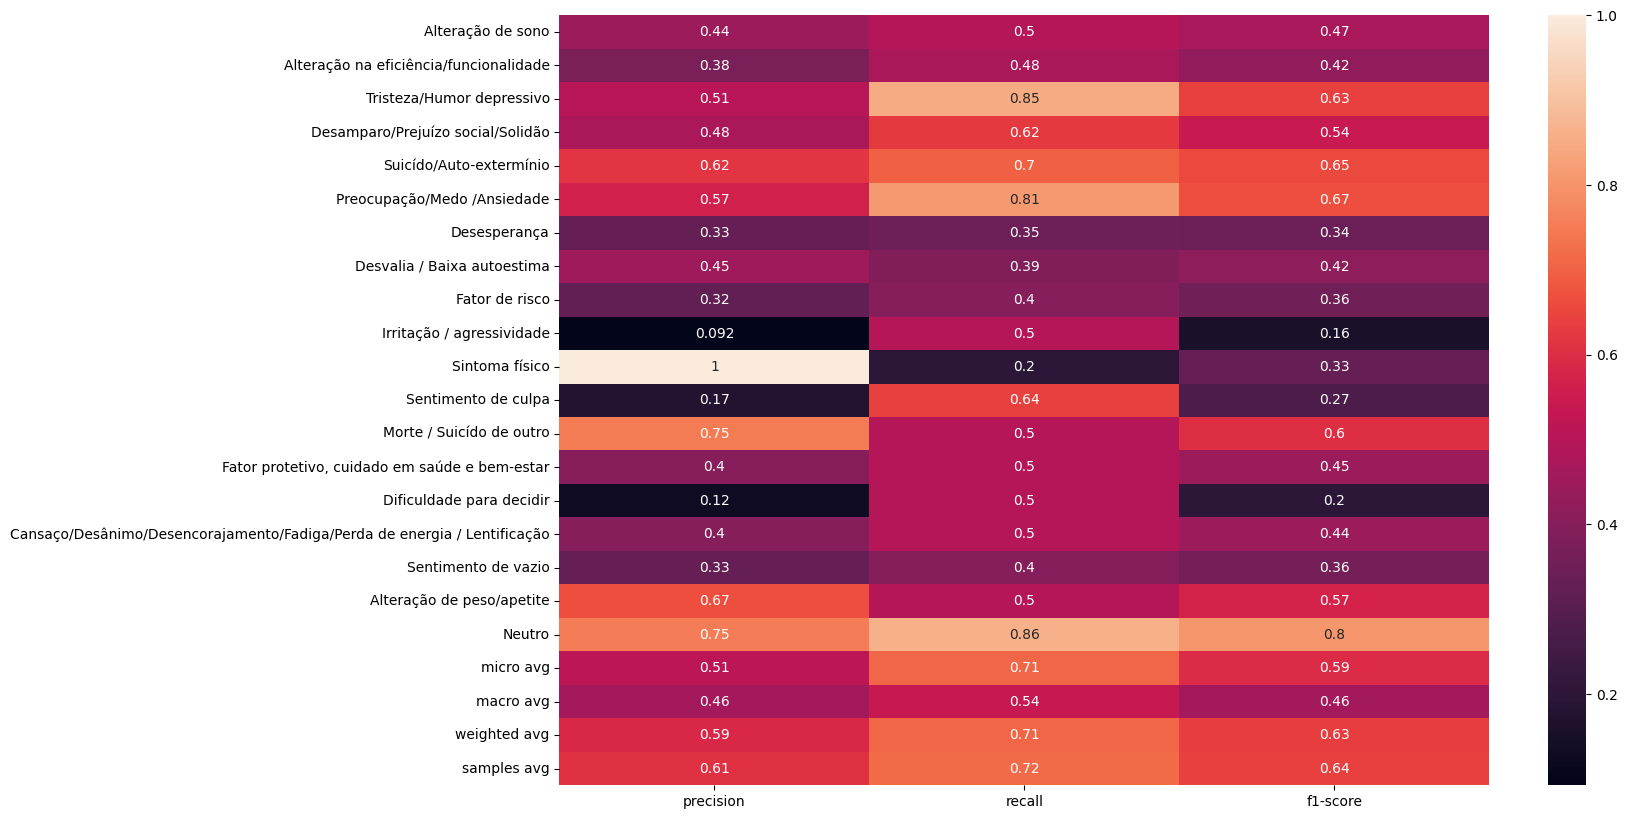

In [46]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(pd.DataFrame(best_fine_tuning_report).iloc[:-1, :].T, annot=True)

# Analisando os casos de erro

primeiro olhando o sintomas que o model erra mais. Lembre-se: o essencial é conhecer os dados!